# Data analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import optuna
import gc

from time import time
from joblib import load, dump
from matplotlib.ticker import MaxNLocator,MultipleLocator
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import clone
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm
import sklearn.metrics as skm
from sklearn.ensemble import StackingRegressor, RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv')
orig_features = train.columns[1:-1].to_list()
train.shape, test.shape

((1117957, 22), (745305, 21))

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

In [4]:
train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,...,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [5]:
train.isna().sum().sum(), train.duplicated().sum() 

(0, 0)

Пропусков и дубликатов нет

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1117957.0,558978.000000,322726.531784,0.000,279489.00,558978.000,838467.00,1117956.000
MonsoonIntensity,1117957.0,4.921450,2.056387,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,1117957.0,4.926671,2.093879,0.000,3.00,5.000,6.00,18.000
RiverManagement,1117957.0,4.955322,2.072186,0.000,4.00,5.000,6.00,16.000
Deforestation,1117957.0,4.942240,2.051689,0.000,4.00,5.000,6.00,17.000
Urbanization,1117957.0,4.942517,2.083391,0.000,3.00,5.000,6.00,17.000
ClimateChange,1117957.0,4.934093,2.057742,0.000,3.00,5.000,6.00,17.000
DamsQuality,1117957.0,4.955878,2.083063,0.000,4.00,5.000,6.00,16.000
Siltation,1117957.0,4.927791,2.065992,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,1117957.0,4.942619,2.068545,0.000,3.00,5.000,6.00,16.000


Все фичи - категориальные признаки, причем средние и медианы фичей примерно одинаковы. 

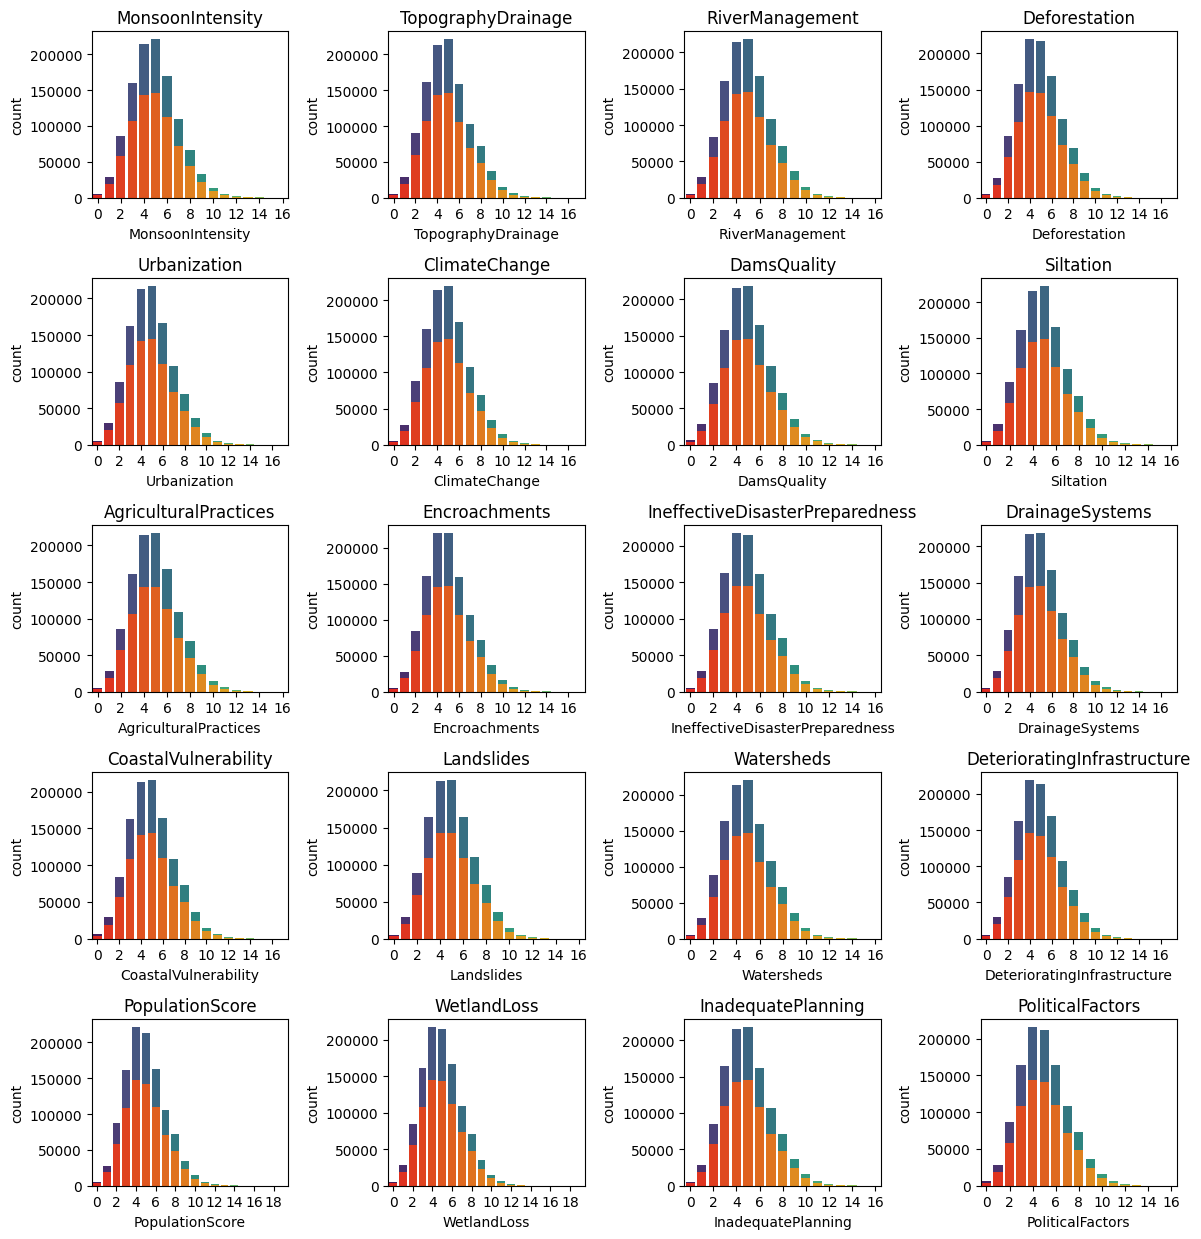

In [7]:
ncol = 4
nrow = int(np.ceil(len(orig_features) / 4))
plt.figure(figsize=(ncol*3, nrow*2.5))
for i,col in enumerate(orig_features):
    ax = plt.subplot(nrow, ncol, i+1)
    sb.countplot(train,x=col,ax=ax,palette='viridis')
    sb.countplot(test,x=col,ax=ax,palette='autumn')
    ax.set_title(col)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout();

Данные с теста и трейна распределены примерно одинаково

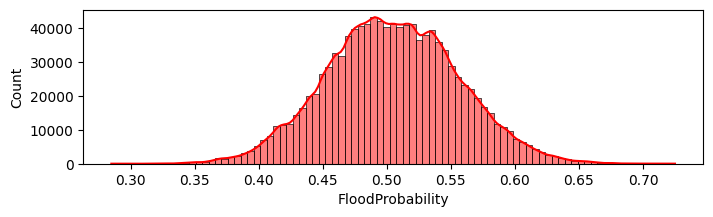

In [8]:
plt.figure(figsize=(8,2))
sb.histplot(train["FloodProbability"], kde=True, \
            bins=np.linspace(train["FloodProbability"].min(), train["FloodProbability"].max(), 88), color='r');
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

Распределение таргета похоже на нормальное с центром в 0.5

# Baseline

Посмотрим, как справляется градиентный бустинг с задачей

In [9]:
X = train.iloc[:,1:-1]
y = train['FloodProbability']
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [10]:
def cross_validate(alg, X, y, repeat=2, SINGLE_FOLD=False):
    
    start_time = time()
    scores = []
    oof_preds = np.full_like(y, np.nan, dtype=float)
    
    for fold,(train_idx, val_idx) in enumerate(kf.split(X, y.astype(str))):
        x_cv_tr, y_cv_tr = X.iloc[train_idx], y.iloc[train_idx]
        x_cv_vl, y_cv_vl = X.iloc[val_idx], y.iloc[val_idx]
        
        y_pred = np.zeros_like(y_cv_vl, dtype=float)
        for i in range(repeat):
            m = clone(alg)
            if repeat > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                mm.set_params(random_state=i)
            m.fit(x_cv_tr, y_cv_tr)
            y_pred += m.predict(x_cv_vl)
        y_pred /= repeat   
        
        score = skm.r2_score(y_cv_vl, y_pred)
        print(f'# Fold {fold}: R2 Score = {score:0.5f}')
        scores.append(score)
        oof_preds[val_idx] = y_pred
        if SINGLE_FOLD: break
        
    total_time = time() - start_time
    if isinstance(m, Pipeline):
        model_name = m[-1].__class__.__name__
    else:
        model_name = m.__class__.__name__
    print(f'# Mean R2 Score = {np.mean(scores):0.5f} ± {np.std(scores):0.5f} for {model_name}\n'
          f'{"Single Fold" if SINGLE_FOLD else ""}'
          f'Time Elapsed: {np.round((total_time / 60),0)} Min\n')

In [11]:
xgr_model = make_pipeline(StandardScaler(),
                          XGBRegressor())

cross_validate(xgr_model, X, y)

# Fold 0: R2 Score = 0.81145
# Fold 1: R2 Score = 0.81086
# Fold 2: R2 Score = 0.81077
# Fold 3: R2 Score = 0.81025
# Fold 4: R2 Score = 0.81068
# Mean R2 Score = 0.81080 ± 0.00039 for XGBRegressor
Time Elapsed: 1.0 Min



# Improve baseline

Все фичи распредлены имеют близкие средние и медианы, давай посмотрим на их сумму

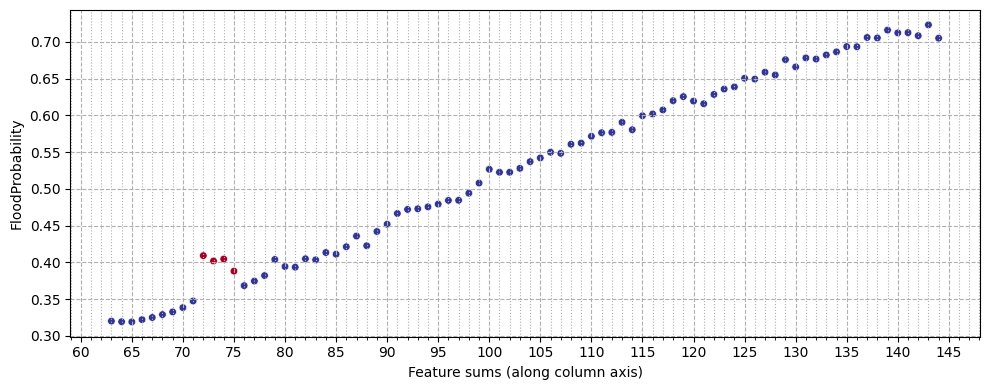

In [12]:
temp = train['FloodProbability'].groupby(X.sum(axis=1)).mean()
plt.figure(figsize=(10,4))
sb.scatterplot(x=temp.index, y=temp, c=temp.index.isin(np.arange(72,76)), s=30, cmap='RdYlBu_r')
plt.gca().xaxis.set_major_locator(MultipleLocator(5))
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.gca().yaxis.set_major_locator(MultipleLocator(0.05))
plt.grid(True, which='major', linestyle='--')
plt.grid(True, which='minor', linestyle=':')
plt.xlabel('Feature sums (along column axis)')
plt.tight_layout()

Видна явная зависимость таргета от суммы всех фичей, добавим ее в данные

In [13]:
def make_features(data, train_data=True, scaler=None):
    '''
    For feature engineering of both train and test data. Returns the data with new features added in standardized form.
    The standardization parameters are learned only from the train data so as to avoid data leakage.
    '''
    df = data.copy()
    with tqdm(total=12 ,desc='processing...') as pbar:
        sort_cols = [f'col{i+1}' for i in range(len(orig_features))]
        
        df['sum'] = df.sum(axis=1)         
        pbar.update(1)
        
        df['linear_ft'] = df['sum'].isin(np.arange(72, 76)).astype(int)
        pbar.update(1)
        
        df['median'] = df[orig_features].median(axis=1)         
        pbar.update(1)
        
        df['std'] = df[orig_features].std(axis=1)         
        pbar.update(1)
        
        df[sort_cols] = np.sort(df[orig_features].values, axis=1)         
        pbar.update(1)
        
        df['mean'] = df[orig_features].mean(axis=1)
        pbar.update(1)
        
        df['max'] = df[orig_features].max(axis=1) 
        pbar.update(1)               
        
        df['min'] = df[orig_features].min(axis=1)
        pbar.update(1)
        
        df['skew'] = df[orig_features].skew(axis=1)
        pbar.update(1)
        
        df['kurt'] = df[orig_features].kurt(axis=1)
        pbar.update(1)
        
        if train_data:
            scaler = StandardScaler()
            scaler.fit(df)
            df[df.columns.to_list()] = scaler.transform(df.values)
            pbar.update(1)
        else:
            df[df.columns.to_list()] = scaler.transform(df.values)
            pbar.update(1)
        
    return df, scaler

In [14]:
train_df, scaler = make_features(X)
dump(train_df,'train_df.joblib')
train_df.head()

processing...:  92%|█████████▏| 11/12 [00:06<00:00,  1.79it/s]


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,col16,col17,col18,col19,col20,mean,max,min,skew,kurt
0,0.038198,1.467769,0.021561,1.490363,0.507578,-0.453941,-0.458881,-0.933107,-0.939124,-0.455632,...,-0.546571,0.240347,-0.384235,-0.05788,-0.967722,-0.576389,-0.967722,0.473994,0.351678,-0.552520
1,0.524488,0.990186,-0.461022,-0.459251,1.467552,1.489938,-0.938943,0.034951,-0.455692,0.504372,...,0.832034,0.240347,0.778443,-0.05788,-0.201344,-0.576389,-0.201344,-1.920120,-0.518854,-0.416219
2,0.524488,0.035021,0.504143,1.002959,-0.932383,1.003968,-1.899068,0.034951,-0.455692,0.024370,...,0.832034,0.240347,-0.384235,-1.08186,-0.967722,0.025493,-0.967722,-0.723063,-1.648163,-0.736429
3,-0.934382,-0.442562,0.504143,0.028152,-0.452396,1.489938,-0.458881,1.003010,0.511171,1.464377,...,0.832034,0.240347,-0.384235,-0.05788,-0.967722,0.627374,-0.967722,0.473994,-0.575221,-0.609961
4,0.038198,-0.920145,-1.426186,0.515556,-0.452396,-0.453941,-0.938943,-0.933107,-0.939124,-0.935635,...,-1.925176,-2.319972,-1.546914,-2.10584,-2.500477,-3.224667,-2.500477,-0.723063,-0.305973,-0.886395


In [15]:
test_df, _ = make_features(test.iloc[:,1:], train_data=False, scaler=scaler)
dump(test_df,'test_df.joblib')
test_df.head()

processing...:  92%|█████████▏| 11/12 [00:03<00:00,  2.97it/s]


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,col16,col17,col18,col19,col20,mean,max,min,skew,kurt
0,-0.448092,0.512604,-0.943604,0.028152,0.507578,1.003968,1.461369,1.003010,1.478035,-0.455632,...,0.832034,0.240347,0.778443,-0.05788,-0.967722,1.470008,-0.967722,1.671050,-0.679136,-0.985432
1,-0.448092,-0.442562,-1.426186,1.977766,0.027591,0.032029,-0.458881,1.003010,0.027740,-0.455632,...,-1.925176,0.240347,-0.384235,-1.08186,-0.201344,-1.057894,-0.201344,-0.723063,0.209093,0.408414
2,-1.906963,-0.920145,0.504143,0.028152,0.987565,-1.425881,-0.458881,0.518981,-0.455692,-1.415637,...,-0.546571,0.240347,-0.384235,-0.05788,-0.201344,-1.057894,-0.201344,-0.723063,-0.202562,-0.814604
3,-1.420672,-0.442562,-0.461022,0.515556,-0.452396,0.032029,-0.458881,-0.933107,-0.455692,-0.455632,...,-0.546571,-1.039812,-0.384235,-1.08186,-0.967722,-0.817142,-0.967722,0.473994,0.155842,-0.230696
4,0.524488,-0.920145,-1.426186,-0.459251,0.507578,-0.453941,0.021182,0.034951,-0.939124,0.984374,...,-0.546571,-1.039812,-1.546914,-1.08186,-0.967722,-0.817142,-0.967722,0.473994,-0.363181,-0.384101


In [16]:
X = train_df
y = train['FloodProbability']

cross_validate(xgr_model, X, y)

# Fold 0: R2 Score = 0.86883
# Fold 1: R2 Score = 0.86894
# Fold 2: R2 Score = 0.86884
# Fold 3: R2 Score = 0.86877
# Fold 4: R2 Score = 0.86867
# Mean R2 Score = 0.86881 ± 0.00009 for XGBRegressor
Time Elapsed: 2.0 Min



# Ensemble

In [17]:
kf = StratifiedKFold(n_splits=7, shuffle=True, random_state=77)
FOLDS = 7

def cross_validate_predict(model, X, y, test_data, repeat=2):
    '''
    Function to make the train preds and test preds using cross validation.
    The resultant ensemble of preds will be further used to make the final test prediction.
    '''
    start_time = time()
    scores = []
    oof_preds_full = np.full_like(y, np.nan, dtype=float)
    test_pred_final = np.zeros(len(test_data), dtype=float)
    
    for fold,(train_idx, val_idx) in enumerate(kf.split(X, y.astype(str))):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        y_val_pred = np.zeros_like(y_val, dtype=float)
        y_pred = np.zeros(len(test_data), dtype=float)
        
        for i in range(repeat):
            m = clone(model)
            if repeat > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                mm.set_params(random_state=i)
            m.fit(X_train, y_train)
            y_val_pred += m.predict(x_val)
            y_pred += m.predict(test_data)
        y_val_pred /= repeat
        y_pred /= repeat
        
        score = skm.r2_score(y_val, y_val_pred)
        print(f'# Fold {fold}: R2 Score = {score:0.5f}')
        scores.append(score)
        oof_preds_full[val_idx] = y_val_pred
        test_pred_final += y_pred
        
    test_pred_final /= FOLDS
    
    total_time = time() - start_time
    if isinstance(m, Pipeline):
        model_name = m[-1].__class__.__name__
    else:
        model_name = m.__class__.__name__
        
    print(f'# Mean R2 Score = {np.mean(scores):0.5f} ± {np.std(scores):0.5f} for {model_name}\n'
          f'Time Elapsed: {np.round((total_time / 60),0)} Min \n')

    return oof_preds_full, test_pred_final

In [18]:
xgr_tr_pred1, xgr_ts_pred1 = cross_validate_predict(XGBRegressor(), X, y, test_df)

cbr_tr_pred2, cbr_ts_pred2 = cross_validate_predict(CatBoostRegressor(verbose=False), X, y, test_df)

lgr_tr_pred3, lgr_ts_pred3 = cross_validate_predict(LGBMRegressor(verbose=0), X, y, test_df)

ridge_tr_pred4, ridge_ts_pred4 = cross_validate_predict(Ridge(), X, y, test_df)

# Fold 0: R2 Score = 0.86941
# Fold 1: R2 Score = 0.86934
# Fold 2: R2 Score = 0.86907
# Fold 3: R2 Score = 0.86865
# Fold 4: R2 Score = 0.86817
# Fold 5: R2 Score = 0.86942
# Fold 6: R2 Score = 0.86787
# Mean R2 Score = 0.86885 ± 0.00058 for XGBRegressor
Time Elapsed: 2.0 Min 

# Fold 0: R2 Score = 0.86952
# Fold 1: R2 Score = 0.86968
# Fold 2: R2 Score = 0.86940
# Fold 3: R2 Score = 0.86895
# Fold 4: R2 Score = 0.86836
# Fold 5: R2 Score = 0.86962
# Fold 6: R2 Score = 0.86815
# Mean R2 Score = 0.86910 ± 0.00058 for CatBoostRegressor
Time Elapsed: 25.0 Min 

# Fold 0: R2 Score = 0.86938
# Fold 1: R2 Score = 0.86949
# Fold 2: R2 Score = 0.86914
# Fold 3: R2 Score = 0.86877
# Fold 4: R2 Score = 0.86814
# Fold 5: R2 Score = 0.86938
# Fold 6: R2 Score = 0.86795
# Mean R2 Score = 0.86889 ± 0.00058 for LGBMRegressor
Time Elapsed: 6.0 Min 

# Fold 0: R2 Score = 0.85226
# Fold 1: R2 Score = 0.85219
# Fold 2: R2 Score = 0.85170
# Fold 3: R2 Score = 0.85146
# Fold 4: R2 Score = 0.85054
# Fold 5

In [19]:
ensemble_train = np.c_[xgr_tr_pred1, cbr_tr_pred2, lgr_tr_pred3, ridge_tr_pred4]
ensemble_test = np.c_[xgr_ts_pred1, cbr_ts_pred2, lgr_ts_pred3, ridge_ts_pred4]

In [20]:
ensemble_train_df = pd.DataFrame({
    'xgr': ensemble_train[:,0],
    'cbr': ensemble_train[:,1],
    'lgr': ensemble_train[:,2],
    'ridge': ensemble_train[:,3],
})
ensemble_test_df = pd.DataFrame({
    'xgr': ensemble_test[:,0],
    'cbr': ensemble_test[:,1],
    'lgr': ensemble_test[:,2],
    'ridge': ensemble_test[:,3],
})

In [21]:
_, ts_pred = cross_validate_predict(
    Ridge(fit_intercept=False, alpha=0.01),
    ensemble_train_df, y, ensemble_test_df)

# Fold 0: R2 Score = 0.86961
# Fold 1: R2 Score = 0.86972
# Fold 2: R2 Score = 0.86943
# Fold 3: R2 Score = 0.86901
# Fold 4: R2 Score = 0.86844
# Fold 5: R2 Score = 0.86969
# Fold 6: R2 Score = 0.86821
# Mean R2 Score = 0.86916 ± 0.00058 for Ridge
Time Elapsed: 0.0 Min 



In [22]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['FloodProbability'] = ts_pred
submission.to_csv('submission.csv',index=False)
submission

,id,FloodProbability
0,1117957,0.577929
1,1117958,0.455907
2,1117959,0.448961
3,1117960,0.466966
4,1117961,0.467514
...,...,...
745300,1863257,0.475046
745301,1863258,0.443848
745302,1863259,0.620745
745303,1863260,0.549358
